## Import standard libraries

In [1]:
import torch
import torch.nn as nn  # we'll use this a lot going forward!
import torch.nn.functional as F

import numpy as np
import warnings

# Import matplotlib library and setup environment for plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
from matplotlib import pyplot as plt, rc

# Import json library and create function to format dictionaries.
import json
format_json = lambda x: json.dumps(x, indent=4)

# Import pandas and set pandas DataFrame visualization parameters
from IPython.display import display
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Set rendering parameters to use TeX font if not working on Juno app.
from pathlib import Path
import os
if not '/private/var/' in os.getcwd():
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 11})
    rc('text', usetex=True)
    
# Get current working directory path for the tool parent folder and print it.
parent_folder = 'Tool'
cwd = str(Path(os.getcwd()[:os.getcwd().index(parent_folder)+len(parent_folder)]))
print('Parent working directory: %s' % cwd)


Parent working directory: /Users/jjrr/Documents/SCA-Project/Tool


## Import user defined libraries

In [2]:
# Import custom libraries from local folder.
import sys
sys.path.append("..")

from library.irplib import utils, eda, config, sdg
from library.irplib import ann

## Data preparation

### Import training dataset

In [3]:
# Import transformed training dataset
df = eda.import_cdm_data(os.path.join(cwd,'data','esa-challenge',
                                      'train_data_transformed.csv'))

# Count number of CDMs available per event
nb_cdms = df.groupby(['event_id']).count()['time_to_tca'] \
            .to_numpy(dtype=np.int16)

# Define window size and number of events to forecast
seq_length = 2
events_to_forecast = 1
min_cdms = seq_length + events_to_forecast

print(f'Events suitable for training (More than {min_cdms-1} CDMs): '
      f'{np.sum(nb_cdms>=min_cdms)}'
      f' ({np.sum(nb_cdms>=min_cdms)/len(nb_cdms)*100:5.1f}%)')
print(f'Time sequences with event_id integrity per feature: '
      f'{np.sum(nb_cdms[nb_cdms>=min_cdms]-min_cdms)}')

# Count number of CDMs per event
ts_events  = df[['event_id', 'time_to_tca']].groupby(['event_id']).count() \
                  .rename(columns={'time_to_tca':'nb_cdms'})

# Get events that have a minimum number of CDMs equal to the window_size + 
# events_to_forecast
events_filter = list(ts_events[ts_events['nb_cdms']>=min_cdms].index.values)

# Redefine DataFrame to contain only events suitable for TSF to save memory
df = df[df['event_id'].isin(events_filter)]

# Show first data points to explore data types
display(df.head(10))
df.info()

Events suitable for training (More than 2 CDMs): 11731 ( 89.2%)
Time sequences with event_id integrity per feature: 124820


,event_id,time_to_tca,mission_id,risk,max_risk_estimate,max_risk_scaling,miss_distance,relative_speed,relative_position_r,relative_position_t,relative_position_n,relative_velocity_r,relative_velocity_t,relative_velocity_n,t_time_lastob_start,t_time_lastob_end,t_recommended_od_span,t_actual_od_span,t_obs_available,t_obs_used,t_residuals_accepted,t_weighted_rms,t_rcs_estimate,t_cd_area_over_mass,t_cr_area_over_mass,t_sedr,t_j2k_sma,t_j2k_ecc,t_j2k_inc,t_ct_r,t_cn_r,t_cn_t,t_crdot_r,t_crdot_t,t_crdot_n,t_ctdot_r,t_ctdot_t,t_ctdot_n,t_ctdot_rdot,t_cndot_r,t_cndot_t,t_cndot_n,t_cndot_rdot,t_cndot_tdot,c_object_type,c_time_lastob_start,c_time_lastob_end,c_recommended_od_span,c_actual_od_span,c_obs_available,c_obs_used,c_residuals_accepted,c_weighted_rms,c_rcs_estimate,c_cd_area_over_mass,c_cr_area_over_mass,c_sedr,c_j2k_sma,c_j2k_ecc,c_j2k_inc,c_ct_r,c_cn_r,c_cn_t,c_crdot_r,c_crdot_t,c_crdot_n,c_ctdot_r,c_ctdot_t,c_ctdot_n,c_ctdot_rdot,c_cndot_r,c_cndot_t,c_cndot_n,c_cndot_rdot,c_cndot_tdot,t_span,c_span,t_h_apo,t_h_per,c_h_apo,c_h_per,geocentric_latitude,azimuth,elevation,mahalanobis_distance,t_position_covariance_det,c_position_covariance_det,t_sigma_r,c_sigma_r,t_sigma_t,c_sigma_t,t_sigma_n,c_sigma_n,t_sigma_rdot,c_sigma_rdot,t_sigma_tdot,c_sigma_tdot,t_sigma_ndot,c_sigma_ndot,F10,F3M,SSN,AP
0,0,0.223828,5,-10.204955,-7.834756,8.602101,0.248717,0.6896,0.113450,0.066407,-0.151853,-0.010286,-0.631850,-0.276295,1.0,0.0,3.78,3.78,459,458,98.9,1.265,0.4020,0.345650,0.119550,-0.658611,0.804718,0.003997,0.528489,-0.397969,0.292258,0.040799,0.394221,-0.999674,-0.038498,-0.981098,0.214612,-0.316493,-0.210247,0.170737,-0.001551,0.531593,0.002117,-0.179278,UNKNOWN,180.0,2.0,15.85,15.85,15,15,100.0,2.360,NaN,0.017435,0.025321,-0.437818,0.060567,0.003144,0.902096,-0.824859,0.473976,-0.002576,0.825216,-0.999998,0.003565,-0.732954,0.220006,-0.814249,-0.220621,0.249855,0.196620,0.722186,-0.196908,-0.668487,1.0,2.0,0.695229,0.635491,0.017385,0.821994,-0.367870,-0.118094,0.001495,0.064715,0.225180,0.638829,0.087542,0.349138,0.307780,0.681469,0.036088,0.240117,-0.119684,0.254070,-0.343672,-0.112597,-0.363352,-0.059420,0,0,0,0
1,0,0.172499,5,-10.355758,-7.848937,8.956374,0.242400,0.6896,0.118575,0.064680,-0.147998,-0.010000,-0.631850,-0.276295,1.0,0.0,3.79,3.79,456,455,98.5,1.270,0.4020,0.337175,0.152317,-0.648106,0.804722,0.003996,0.528489,-0.073137,0.297366,0.060541,0.069652,-0.998192,-0.052511,-0.994240,-0.029644,-0.302333,0.034030,0.179696,0.001552,0.561142,-0.005165,-0.181036,UNKNOWN,180.0,2.0,15.85,15.85,15,15,100.0,2.360,NaN,0.017435,0.025321,-0.437818,0.060569,0.003144,0.902096,-0.818207,0.482754,-0.003578,0.818573,-0.999998,0.004574,-0.728759,0.202595,-0.817490,-0.203216,0.258964,0.195718,0.721903,-0.196008,-0.674979,1.0,2.0,0.695225,0.635500,0.017386,0.822013,-0.367853,-0.118094,0.001454,0.135770,0.194086,0.638635,0.078774,0.348067,0.251663,0.681141,0.036770,0.240094,-0.176181,0.253741,-0.349081,-0.112847,-0.364476,-0.059431,0,0,0,0
2,0,0.136028,5,-10.345631,-7.847406,8.932195,0.241250,0.6896,0.118650,0.064402,-0.147290,-0.010000,-0.631850,-0.276295,1.0,0.0,3.79,3.80,456,455,98.5,1.257,0.4020,0.333925,0.117617,-0.647529,0.804722,0.003996,0.528489,-0.109230,0.305189,0.043711,0.107079,-0.996235,-0.034287,-0.996674,0.033933,-0.308501,-0.030161,0.123760,0.019630,0.579274,-0.023726,-0.125737,UNKNOWN,180.0,2.0,15.85,15.85,15,15,100.0,2.360,NaN,0.017435,0.025321,-0.437818,0.060570,0.003144,0.902096,-0.817408,0.483828,-0.003742,0.817774,-0.999998,0.004738,-0.729083,0.201698,-0.817662,-0.202320,0.260092,0.195558,0.721854,-0.195849,-0.675347,1.0,2.0,0.695229,0.635497,0.017386,0.822018,-0.367850,-0.118094,0.001454,0.173950,0.179284,0.638599,0.075784,0.347942,0.226518,0.681078,0.037494,0.240090,-0.202350,0.253678,-0.352092,-0.112859,-0.363766,-0.059433,0,0,0,0
3,0,0.082810,5,-10.337809,-7.845880,8.913444,0.242983,0.6896,0.118175,0.064877,-0.148341,-0.010000,-0.631850,-0.276295,1.0,0.0,3.86,3.86,443,442,98.4,1.254,0.4020,0.337250,0.091333,-0.643061,0.8

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160013 entries, 0 to 162633
Columns: 103 entries, event_id to AP
dtypes: category(7), float64(88), int16(8)
memory usage: 112.9 MB


## Time-Series Forecasting problem

### Converting data from Pandas DataFrame to Time-Series Pytorch Tensors

In [4]:
# Get inputs and outputs in the right shape to feed the LSTM model
output_features = config.get_features(**{'continuous':True, 'variable': True, 
                                         'cluster':'relative_state'})
input_features  = output_features 

# Get input and output size from the list of features
input_size = len(input_features)
output_size = len(output_features)

print(f'Inputs ({input_size}): {input_features} '
      f'\nOutputs ({output_size}): {output_features} ')

Inputs (3): ['relative_position_r', 'relative_position_t', 'relative_position_n'] 
Outputs (3): ['relative_position_r', 'relative_position_t', 'relative_position_n'] 


In [7]:
# Get input variable features from config file.
features = input_features

# Check if file containing tensors is available in the data folder and load it
# tsf_tensors = torch.load(filepath) if os.path.exists(filepath) else {}
tsf_tensors = {}

# Iterate over all features to get the time series subsets
pb_features = utils.progressbar(iterations = range(len(features)), 
                                desc_loc='right')

time_to_tca = df['time_to_tca'].to_numpy(dtype='float32')
for f in pb_features.iterations:

    # Initialize list of tensors for feature f
    feature = features[f]
    
    # Get filename and filepath and check if it already exists
    filename = f'ts_ann_{feature}.pt'
    filepath = os.path.join(cwd,'data','tensors', filename)

    if os.path.exists(filepath):
        # If tensors already exists, load them.
        description = f'> Loading tensors from feature {feature} ...'
        pb_features.refresh(i = f+1, description = description)
        
        tsf_tensors[feature] = torch.load(filepath)
    else:

        # If tensor do not exist for a feature, initialize and get all 
        # time-series
        tsf_tensors[feature] = []

        # Get full sequence from dataset and convert it to a tensor.
        feature_dtype = str(df[feature].dtype).lower()
        data = df[feature].to_numpy(dtype=feature_dtype)

        for e, event_id in enumerate(events_filter):

            # Print progress bar
            subprogress = (e+1)/len(events_filter)*100
            description = f'> Extracting sequences of time-series from ' + \
                          f' feature {feature:<30s}  ' + \
                          f'(Progress: {subprogress:5.1f}%)'
            pb_features.refresh(i = f+1, description = description)

            # Get full sequence from dataset and convert it to a tensor.
            event_filter = (df['event_id']==event_id)
            feature_seq = torch.nan_to_num(torch.FloatTensor(data[event_filter]))
            time_seq = torch.nan_to_num(torch.FloatTensor(time_to_tca[event_filter]))

            # Add Time-Series subsets from full sequence tensor and add it to 
            # the list for the feature f
            tsf_tensors[feature] = tsf_tensors[feature] + \
                                   ann.event_ts_sets(feature_seq, time_seq)

        # Save tensors containing all Time-Series subsets for training organised 
        # by feature.
        description = f'Saving tensors with sequences of time-series into' + \
                      f' external file {"."*(len(description)-64)}'
        torch.save(tsf_tensors[feature], 
                   os.path.join(cwd,'data','tensors', filename))
        pb_features.refresh(i = f+1, description = description)


> 100% |██████████| 3/3 | Remaining time: 00:00 (2.01 it/s) > Loading tensors from feature relative_position_n ...


### Get Inputs and Outputs tensors from Time-Series

In [8]:
tsf_tensors['relative_position_r'][0]

(array([0.11345   , 0.118575  , 0.05132924], dtype=float32),
 array([0.11865   , 0.03647155], dtype=float32))

In [7]:
# Get Time series data from tensors
ts_data  = rnn.tsf_iotensors(tsf_tensors, input_features, seq_length)

# Tensor with shape (batch_size, seq_length, input_size)
inputs  = ts_data['inputs']

# Tensor with shape (batch_size, output_size)
outputs = ts_data['outputs'][ :, :output_size] 

NameError: name 'rnn' is not defined

In [12]:
batch = 1

# Inputs shape is (batch_size, seq_length, input_size)
print(inputs[batch, :, :]) 

# Outputs shape is (batch_size, input_size)
print(outputs[batch])      

tensor([[-0.2903, -0.0703,  0.2450, -0.0059,  0.3605, -0.0361, -0.0028, -0.9999,
          0.0359, -0.9973, -0.0681, -0.3570,  0.0768, -0.0272,  0.0843, -0.4423,
         -0.0850,  0.0210, -0.0677,  0.6370, -0.0381,  0.0635, -1.0000,  0.0367,
         -0.9963,  0.1531, -0.6350, -0.1489,  0.7159, -0.1588,  0.9540,  0.1565,
         -0.7233,  0.1373,  0.3469,  0.3431,  0.6592,  0.0323,  0.3366, -0.0861,
          0.2300, -0.2919, -0.0819, -0.3461, -0.0675],
        [-0.1747, -0.0575,  0.2005, -0.2226,  0.4259, -0.1497,  0.2068, -0.9995,
          0.1473, -0.9995,  0.1911, -0.4237, -0.1751,  0.0827,  0.0170, -0.4054,
         -0.0186, -0.0838,  0.0260,  0.5636,  0.0652, -0.0452, -0.9996, -0.0759,
         -0.9998, -0.0060, -0.5641,  0.0253,  0.7036, -0.0270,  0.9166,  0.0073,
         -0.7063,  0.1435,  0.2425,  0.3002,  0.4895,  0.0376,  0.2791, -0.1291,
          0.0601, -0.2862, -0.1867, -0.3457, -0.1028],
        [-0.1750, -0.0577,  0.2011, -0.2301,  0.2368, -0.0460,  0.2229, -0.9998,

#### Training and test split on inputs/outputs tensors

In [8]:
train_split = 0.75

batch_size, seq_length, inputs_size = inputs.size()

train_size = int(((batch_size*train_split)//1000)*1000)
test_size = batch_size - train_size

print(f'Train size: {train_size} sequences \n Test size: {test_size} sequences')

X_train = inputs[:train_size-test_size]
X_test  = inputs[train_size-test_size:train_size]

y_train = outputs[:train_size-test_size]
y_test  = outputs[train_size-test_size:train_size]

Train size: 78000 sequences 
 Test size: 26099 sequences


### Neural network class definition and instanciation of the model

#### Definition of `LSTMtoLinear()` class

In [9]:
class LSTMtoLinear(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, 
                 num_layers = 1, batch_first = True, bidirectional = False):
        super(LSTMtoLinear, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bidirectional = bidirectional

        self.model = nn.ModuleDict({
            'lstm': nn.LSTM(
                input_size = input_size,    # 45, see the data definition
                hidden_size = hidden_size,  # Can vary
                num_layers = num_layers,
                batch_first = batch_first,
            ),
            'linear': nn.Linear(
                in_features = hidden_size * (2 if bidirectional else 1),
                out_features = output_size,
            )
        })

    def forward(self, inputs):

        seq_length, batch_size, input_size = inputs.size()
       
        # Data is fed to the LSTM
        #  - input: tensor shape depending on batch_first parameter:
        #       if False -> (seq_length, batch_size, input_size)
        #       if True  -> (batch_size, seq_length, input_size)
        #
        #  - output: tensor shape depending on batch_first parameter:
        #       if False -> (seq_length, batch_size, D * hidden_size) 
        #       if True  -> (batch_size, seq_length, D * hidden_size)
        #       where D=2 if bidirectional=True, D=1 otherwise.

        # The output from LSTM is one prediction per each input timestep, 
        # even though only the last timestep’s output is required.
        lstm_out, lstm_states = self.model['lstm'](inputs)
        # print(f'LSTM output size = {lstm_out.size()}')

        # Data is fed to the Linear layer:
        #  - input: (*, input_size), where * means any number of dimensions 
        #           including None.
        #  - output: (*, output_size), where all but the last dimension are the 
        #           same shape as the input.
        linear_out = self.model['linear'](lstm_out[:, -1, :])
        # print(f'Linear Regression output size = {linear_out.size()}')

        # # The prediction utilizing the whole sequence is the last one
        # y_pred = linear_out[:, :, -1].unsqueeze(-1)
        # print(f'y_pred={y_pred.size()}')

        return linear_out

### RNN model: `MultiEventPropagation` class

In [10]:

# Define Multivariate LSTM network class
class MultiEventPropagation(nn.Module):
    def __init__(self, input_size, output_size, layers, p = 0.5):
        super(MultiEventPropagation, self).__init__()
        self.input_size = input_size    # Number of input features
        self.output_size = output_size  # Number of outputs
        self.layers = layers    # Number of recurrent (stacked) layers
    
        layerlist = []
        n_in = input_size
        for l, layer in enumerate(layers):

            # On layer l, which contains n_neurons, perform the following operations:
            # 1. Apply Linear or LSTM to Linear neural network layer

            layer_type = layer['type']
            layer_neurons = layer['neurons']
            kwargs = layer.get('lstm_config', {'num_layers':1, 'batch_first': True})

            if layer_type == 'linear':
                layerlist.append(nn.Linear(n_in, layer_neurons['output']))
            else:

                layerlist.append(LSTMtoLinear(input_size = n_in, 
                                            hidden_size = layer_neurons['hidden'],
                                            output_size = layer_neurons['output'],
                                            num_layers = kwargs.get('num_layers', 1),
                                            batch_first = kwargs.get('batch_first', True)))

            # 2. Apply Hyperbolic Tangent activation function (al(z))
            layerlist.append(nn.Tanh())
            
            # 3. Normalize data using the layer n_neurons
            if l+1<len(layers) and layers[l+1]['type']=='linear':
                layerlist.append(nn.BatchNorm1d(layer_neurons['output']))
            
            # 4. Cancel out a random proportion p of the neurons to avoid overfitting
            layerlist.append(nn.Dropout(p))

            # 5. Set new number of input features n_in for the next layer l+1.
            n_in = layer_neurons['output']

        # Set the last layer of the list which corresponds to the final output
        layerlist.append(nn.Linear(n_in, output_size))

        # Instantiate layers as a Neural Network sequential task
        self.layers = nn.Sequential(*layerlist)
        
    def forward(self, inputs): 

        # Process all data points with the layers functions (sequential of operations)
        outputs = self.layers(inputs)
        
        return outputs

## Model training

In [14]:
# Instanciate model with required inputs.
torch.manual_seed(42)

layers = [{'type':'linear', 'neurons':{'output':300}},
          {'type':'lstm',   'neurons':{'output':200, 'hidden': 200}},
          {'type':'linear', 'neurons':{'output':100}},
          {'type':'linear', 'neurons':{'output':50}}]

model = MultiEventPropagation(input_size = input_size,
                              output_size = output_size,
                              layers = layers)

# Define criterion, optimizer, and scheduler (dynamic learning rate adapter)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

# Print model
print(model)

MultiEventPropagation(
  (layers): Sequential(
    (0): Linear(in_features=45, out_features=300, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.5, inplace=False)
    (3): LSTMtoLinear(
      (model): ModuleDict(
        (lstm): LSTM(300, 200, batch_first=True)
        (linear): Linear(in_features=200, out_features=200, bias=True)
      )
    )
    (4): Tanh()
    (5): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=200, out_features=100, bias=True)
    (8): Tanh()
    (9): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.5, inplace=False)
    (11): Linear(in_features=100, out_features=50, bias=True)
    (12): Tanh()
    (13): Dropout(p=0.5, inplace=False)
    (14): Linear(in_features=50, out_features=3, bias=True)
  )
)


In [15]:
import time
import torch.utils.data as torch_data
start_time = time.time()

epochs = 500
batch_size = 1000

# Initialize array of inf values for losses
losses = np.ones(epochs)*np.inf
lr = np.zeros(epochs)

loader = torch_data.DataLoader(torch_data.TensorDataset(X_train, y_train), shuffle = True, batch_size = batch_size)

# Iterate over all remaining features to get the time series subsets
pb_epochs = utils.progressbar(range(epochs), description='Training Conjunction Event Propagation model ...', desc_loc='right')

for e in pb_epochs.iterations:
    
    lr[e] = rnn.get_lr(optimizer)
    model.train()

    # Train model by passing n batches depending on the batch_size
    # batches = range(0, len(X_train), batch_size)
    batch_losses = np.ones(len(loader))*np.inf

    
    # for b, batch in enumerate(batches):
        
    #     # Get inputs and outputs for batch b
    #     upper_limit = batch+batch_size if batch+batch_size<len(inputs_train) else len(inputs_train)
    #     X_batch = X_train[batch:upper_limit]
    #     y_batch = y_train[batch:upper_limit]

    for b, (X_batch, y_batch) in enumerate(loader):  
        
        # Reset Gradient from the optimizer (hidden and cell states)
        optimizer.zero_grad()
        
        # Initialize hidden state and compute outputs
        y_pred = model(X_batch) 
        
        # Compute loss using the outputs for the batch b and store values in array
        loss = criterion(y_pred, y_batch)  
        batch_losses[b] = loss.detach().numpy()
        
        # Back propagate loss and adjust parameters of the optimizer
        loss.backward()
        optimizer.step()

    losses[e] = batch_losses[-1] 

    # Update progress bar
    description = f'> Training Event Propagation model | LR = {lr[e]:1.2e} | MSE = {losses[e]:10.8f} | RMSE = {np.sqrt(losses[e]):10.8f}'
    pb_epochs.refresh(e+1, description = description)

    # # Validation
    # if e % 100 != 0: continue

    # model.eval()
    # with torch.no_grad():
    #     y_pred = model(X_train)
    #     train_mse = np.sqrt(criterion(y_pred, y_train))
    #     y_pred = model(X_test)
    #     test_mse = np.sqrt(criterion(y_pred, y_test))
    # print(f'Epoch {epoch}: Train RMSE {train_rmse:10.4f}, Test RMSE {test_rmse:10.4f}')

    # Adjust learning rate
    scheduler.step(loss)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

# Model validation
model.eval()
with torch.no_grad():
    y_pred = model(X_train)
    train_rmse = np.sqrt(criterion(y_pred, y_train))
    y_pred = model(X_test)
    test_rmse = np.sqrt(criterion(y_pred, y_test))
print(f'Model validation results:\n - Train: MSE {train_rmse**2:10.4f} RMSE {train_rmse:10.4f}'
      f'\n - Test:  MSE {test_rmse**2:10.4f} RMSE {test_rmse:10.4f}')

> 100% |██████████| 500/500 | Remaining time: 00:00 (0.33 it/s) > Training Event Propagation model | LR = 1.95e-08 | MSE = 0.00750998 | RMSE = 0.08666015

Duration: 1561 seconds
Model validation results:
 - Train: MSE     0.0029 RMSE     0.0541
 - Test:  MSE     0.0030 RMSE     0.0550


In [29]:
batch_example = 200

with torch.no_grad():
    y_pred = model(X_test[batch_example:batch_example+1])[0]
y_true = y_test[batch_example]

print(y_true)
print(y_pred)
print(y_true-y_pred)
print(np.sqrt(criterion(y_pred, y_true)))

tensor([0.0082, 0.0055, 0.0100])
tensor([0.0102, 0.0118, 0.0297])
tensor([-0.0020, -0.0062, -0.0197])
tensor(0.0120)


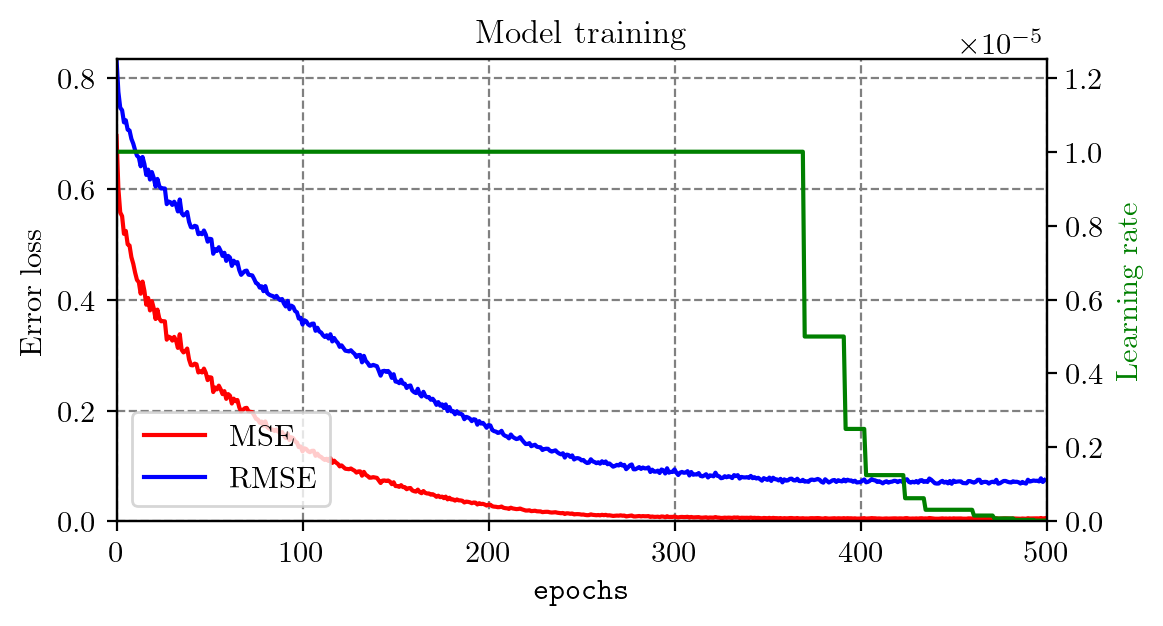

In [13]:
fig, ax1 = plt.subplots(figsize=(6,3))
plt.title(r'Model training', fontsize=12)
ax2 = ax1.twinx()
ax1.set_xlim(0, epochs)
ax1.set_ylim(0,max(np.max(losses),np.sqrt(np.max(losses))))
ax2.set_ylim(0,np.max(lr)*1.25)
ax1.plot(range(0,epochs), losses, 'r-', label=r'MSE')
ax1.plot(range(0,epochs), np.sqrt(losses), 'b-', label=r'RMSE')
ax2.plot(range(0,epochs), lr, 'g-', label=r'Learning rate')

ax1.set_xlabel(r'\texttt{epochs}')
ax1.set_ylabel(r'Error loss')
ax2.set_ylabel(r'Learning rate', color='g')
ax1.grid(True, linestyle='--', c='grey')
ax1.legend(loc='lower left')
plt.show()




In [14]:
model.init_hidden(inputs_test[:1].size(0))
forecast_val = model(inputs_test[:1])
print(features)
print(inputs_test[0])
print(forecast_val[0])
print(outputs_test[0])

# Evaluate entire dataset
with torch.no_grad():

    model.init_hidden(inputs_test.size(0))
    forecast_val = model(inputs_test)
    loss = criterion(forecast_val, outputs_test)
print(f'MSE loss on test dataset: {loss:.8f}')

['t_cd_area_over_mass', 't_cr_area_over_mass', 'c_cd_area_over_mass', 'c_cr_area_over_mass']
tensor([[0.1924, 0.0000, 0.0005, 0.0000],
        [0.1961, 0.0000, 0.0007, 0.0000],
        [0.1980, 0.0000, 0.0009, 0.0000],
        [0.1919, 0.0000, 0.0010, 0.0000],
        [0.1943, 0.0000, 0.0009, 0.0000]])
tensor([ 1.9661e-01,  1.9821e-02,  7.9015e-04, -1.4404e-04],
       grad_fn=<SelectBackward0>)
tensor([0.1953, 0.0000, 0.0007, 0.0000])
MSE loss on test dataset: 0.00286999


# Tests

#### RNN with a single LSTM-Linear layer.

In [ ]:
# Define Multivariate LSTM network class
class EventPropagation(nn.Module):
    def __init__(self,input_size, hidden_size, output_size, seq_length, num_layers=1):
        super(EventPropagation, self).__init__()
        self.input_size = input_size    # Number of input features
        self.hidden_size = hidden_size  # Number of hidden neurons
        self.output_size = output_size  # Number of outputs
        self.num_layers = num_layers    # Number of recurrent (stacked) layers
        self.seq_length = seq_length
    
        self.lstm = nn.LSTM(input_size = self.input_size, 
                            hidden_size = self.hidden_size,
                            num_layers = self.num_layers,
                            batch_first = True)
        # according to pytorch docs LSTM output is 
        # (batch_size,seq_len, num_directions * hidden_size)
        # when considering batch_first = True
        self.linear = nn.Linear(self.hidden_size*self.seq_length, 
                                self.output_size)
    
    
    def forward(self, inputs):        
        batch_size, seq_length, input_size = inputs.size()
        
        lstm_out, lstm_states = self.lstm(inputs)
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
        inputs = lstm_out.contiguous().view(input_size,-1)
        outputs = self.linear(inputs)
        
        return outputs

In [ ]:
# Instanciate model with required inputs.
torch.manual_seed(42)
model = rnn.EventPropagation(input_size = len(features), 
                         hidden_size = 100,
                         output_size = len(features),
                         seq_length = seq_length)

# Define criterion, optimizer, and scheduler (dynamic learning rate adapter)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.1)

# Print model
print(model)

EventPropagation(
  (lstm): LSTM(4, 100, batch_first=True)
  (linear): Linear(in_features=500, out_features=4, bias=True)
)


In [ ]:
# A batch is in shape [batches, batch_size, seq_length, input_size]  
x=torch.Size([128, 30, 12, 45])
y=torch.Size([128, 30, 1, 1])

class MockupModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = nn.ModuleDict({
            'lstm': nn.LSTM(
                input_size=x_features,    # 45, see the data definition
                hidden_size=hidden_size,  # Can vary
            ),
            'linear': nn.Linear(
                in_features=hidden_size,
                out_features=1)
        })

    def forward(self, x):

        # From [batches, batch_size, seq_length, input_size]
        # to [seq_length, batch_size, input_size]
        x = x.view(x_seq_len, -1, x_features)
       
        # Data is fed to the LSTM
        out, _ = self.model['lstm'](x)
        print(f'lstm output={out.size()}')

        # From [seq len, batch, num_directions * hidden_size]
        # to [batches, seqs, seq_len,prediction]
        out = out.view(x_batches, x_seqs, x_seq_len, -1)
        print(f'transformed output={out.size()}')

        # Data is fed to the Linear layer
        out = self.model['linear'](out)
        print(f'linear output={out.size()}')

        # The prediction utilizing the whole sequence is the last one
        y_pred = out[:, :, -1].unsqueeze(-1)
        print(f'y_pred={y_pred.size()}')

        return y_pred